<a href="https://colab.research.google.com/github/amattu2/INST-447/blob/master/Assignments/4/4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment 4
Author: Alec M.

Date: 04/19/2022

Class: INST 447 (SP22)

## Goal
Use the Food Data Central API to pull the nutritional content of a typical Thanksgiving Meal

## Research Questions
1. Is there an association between the amount of protein and energy in a food?
2. Which food is the most nutritious?
3. Which food is the least nutritious?

## Workspace Preparation

In [1]:
# Import modules
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize

# Configure MPL
%matplotlib inline

In [ ]:
# Define USDA API Key
apiKey = "Bq9wAKJOhGuIHG1Z7y0gSwRAZYsOLQVY9lZHPtv9"

In [ ]:
# sample call so we can see the structure of the json file
response = requests.post(
       r'https://api.nal.usda.gov/fdc/v1/search',
       params = {'api_key': apiKey},
       json = {'generalSearchInput': "apple"}
   )
    
# save to JSON
item = response.json()

In [ ]:
print(item)

{'totalHits': 22627, 'currentPage': 1, 'totalPages': 453, 'pageList': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'foodSearchCriteria': {'generalSearchInput': 'apple', 'pageNumber': 1, 'numberOfResultsPerPage': 50, 'pageSize': 50, 'requireAllWords': False}, 'foods': [{'fdcId': 454004, 'description': 'APPLE', 'lowercaseDescription': 'apple', 'dataType': 'Branded', 'gtinUpc': '867824000001', 'publishedDate': '2019-04-01', 'brandOwner': 'TREECRISP 2 GO', 'ingredients': 'CRISP APPLE.', 'marketCountry': 'United States', 'foodCategory': 'Pre-Packaged Fruit & Vegetables', 'modifiedDate': '2017-07-14', 'dataSource': 'LI', 'servingSizeUnit': 'g', 'servingSize': 154.0, 'householdServingFullText': '5.5 ONZ', 'allHighlightFields': '<b>Ingredients</b>: CRISP <em>APPLE</em>.', 'score': 926.5999, 'foodNutrients': [{'nutrientId': 1087, 'nutrientName': 'Calcium, Ca', 'nutrientNumber': '301', 'unitName': 'MG', 'derivationCode': 'LCCD', 'derivationDescription': 'Calculated from a daily value percentage per serving 

In [ ]:
# create list of foods we want to pass through to our API call
food_list=["pizza","fried chicken", "apple", "banana", "bread", "smoothie", "fries", "fish", "shrimp", "crab"]

In [ ]:
# counter that allows us to see which food word is being processed in the loop
counter = 0

# for each food, pull nutritional value

# use for loop to create api call
for food in food_list:

    # increment counter for sequence of foods
    counter=counter+1
    
    # send API request - this should look familiar! From Module 8 - Web Scraping/APIs
    response = requests.post(
        r'https://api.nal.usda.gov/fdc/v1/search',
        params = {'api_key': apiKey},
        json = {'generalSearchInput': food}
    )
    
    # save to JSON
    item = response.json()
    
    # get total matches (there can be multiple hits for one food keyword, so we need to take the length of the match object to see how many matches we got)
    l = [i for i in range(len(item['foods']))]
    
    # for each match
    for i in l:
        # create df of food nutrients across all matches - this should look familiar! From Module 5 - Data Structures
        if i == 0: # for the first match, initialize the dataframe
            rdf = pd.json_normalize(item['foods'][i]['foodNutrients']) # convert json to data frame
        else: # for subsequent matches, create a dataframe (with a different name to be concatenated)
            df = pd.json_normalize(item['foods'][i]['foodNutrients'])
            rdf = pd.concat([rdf,df]) # concatenate dataframes - this should look familiar! From Module 4 - Data Wrangling 

    # Now we have a dataframe with all the matches for a food word
    
    # recode variable values to simplify names
    rdf['nutrientName'].replace('Energy','Energy',inplace=True)
    rdf['nutrientName'].replace('Carbohydrate, by difference','Carbs',inplace=True)
    rdf['nutrientName'].replace('Protein','Protein',inplace=True)
    rdf['nutrientName'].replace('Fiber, total dietary','Fiber',inplace=True)
    rdf['nutrientName'].replace('Total lipid (fat)','Fat',inplace=True)
    rdf['nutrientName'].replace('Sodium, Na','Sodium',inplace=True)
    rdf['nutrientName'].replace('Fatty acids, total saturated','Sat_Fatty_Acids',inplace=True)
    rdf['nutrientName'].replace('Calcium, Ca','Calcium',inplace=True)
    rdf['nutrientName'].replace('Iron, Fe','Iron',inplace=True)
    rdf['nutrientName'].replace('Sugars, total including NLEA','Sugar',inplace=True)
    rdf['nutrientName'].replace('Cholesterol','Chol',inplace=True)
    rdf['nutrientName'].replace('Fatty acids, total trans','Trans_Fatty_Acids',inplace=True)
    rdf['nutrientName'].replace('Vitamin C, total ascorbic acid','VitaminC',inplace=True)
    rdf['nutrientName'].replace('Vitamin A, IU','VitaminA',inplace=True)
    rdf['nutrientName'].replace('Potassium, K','Potassium',inplace=True)
    rdf['nutrientName'].replace('Fatty acids, total polyunsaturated','Unsat_Fatty_Acids',inplace=True)   
  
    # Since we have multiple matches for a food word, lets aggregate to one row per food match/nutrient by finding the average 
    # nutrient value across all matches
    # find average nutrient
    agg_food = rdf[['nutrientName','value']].groupby(['nutrientName']).agg('mean')
    
    # reset index
    agg_food = agg_food.reset_index()
    
    # rename columns
    agg_food.columns = ["nutrientName","Value"]    
    
    # subset data to only include the nutrients we want
    agg_food = agg_food[agg_food["nutrientName"].isin(['Energy','Carbs','Protein','Fiber','Fat'])]

     
    # set food name into a variable so we know what values each food is associated with
    agg_food["Food"] = food 
        
    # transpose the data so the nutrient values are their own columns
    new=agg_food.pivot_table(index=["Food"], columns=['nutrientName'], values='Value')
    
    # reset the index
    new.reset_index(inplace=True)
    
    # append food match to a dataframe with all foods
    if counter ==1: # initialize the df
        all_foods=new
    else:
        all_foods=pd.concat([all_foods,new]) 

In [ ]:
# print dataframe
all_foods

nutrientName,Food,Carbs,Energy,Fat,Fiber,Protein
0,pizza,29.2154,577.666667,12.04200,1.770000,11.279400
0,fried chicken,12.1390,607.923077,16.08280,0.878723,19.501800
0,apple,25.4572,234.552239,3.83664,2.017234,1.352460
0,banana,31.0332,329.671053,3.60140,2.153061,1.860200
0,bread,80.2660,564.650000,8.21340,5.297917,13.689800
0,smoothie,18.9816,120.476190,1.71920,1.110638,1.897600
0,fries,18.8126,308.259259,12.80140,1.374000,11.378400
0,fish,5.9992,513.023529,13.83460,0.406250,14.232000
0,shrimp,2.1214,104.840000,2.03980,0.168000,18.825200
0,crab,8.0040,213.508197,7.96580,0.380000,12.816735


Text(0.5, 1.0, 'RQ1: Is there an association between the amount of carbs and fiber in a food?')

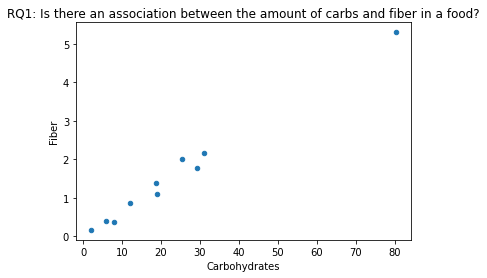

In [ ]:
# RQ1: Is there an association between the amount of carbs and fiber in a food?
# Create a scatterplot
all_foods.plot.scatter(x='Carbs',y='Fiber')

# Add axis labels
plt.xlabel("Carbohydrates")
plt.ylabel("Fiber")

# add title
plt.title("RQ1: Is there an association between the amount of carbs and fiber in a food?")


Text(0.5, 1.0, 'RQ2: Which food has the most carbs?')

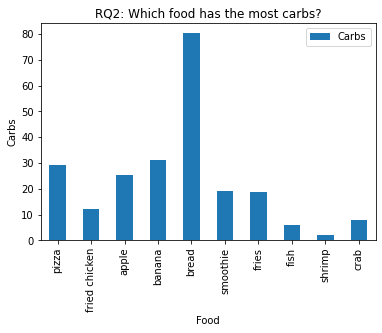

In [ ]:
# RQ2: Which food has the most carbs?
# Create a scatterplot
all_foods.plot.bar(x='Food',y='Carbs')

# Add axis labels
plt.xlabel("Food")
plt.ylabel("Carbs")

# add title
plt.title("RQ2: Which food has the most carbs?")

Text(0.5, 1.0, 'RQ3: Which food has the most fat?')

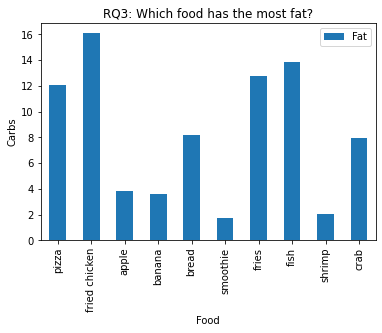

In [ ]:
# RQ3: Which food has the most fat?
# Create a scatterplot
all_foods.plot.bar(x='Food',y='Fat')

# Add axis labels
plt.xlabel("Food")
plt.ylabel("Carbs")

# add title
plt.title("RQ3: Which food has the most fat?")